## The program using Autograd

The network will be the similar as for the exponential decay example, but with some small modifications for our problem.

https://compphysics.github.io/MachineLearning/doc/pub/odenn/html/._odenn-bs018.html

C:\Users\KarlH\Anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Initial cost: 0.221805
Final cost: 0.000417932
The max absolute difference between the solutions is: 0.00424909


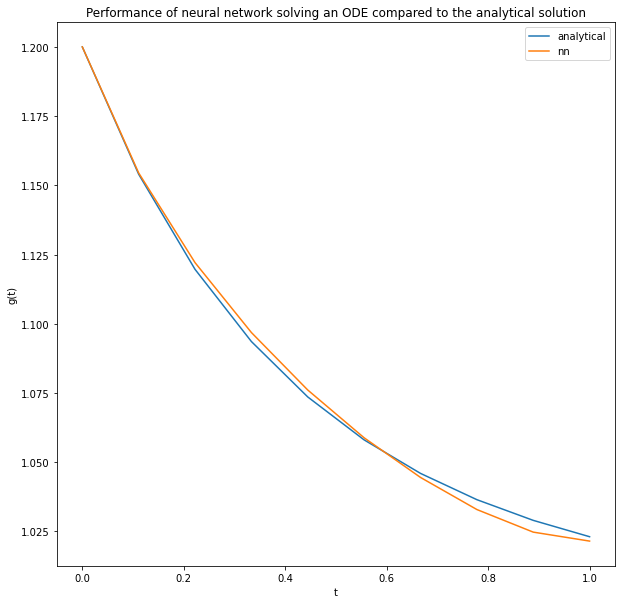

In [1]:
import autograd.numpy as np
from autograd import grad, elementwise_grad
import autograd.numpy.random as npr
from matplotlib import pyplot as plt

def sigmoid(z):
    return 1/(1 + np.exp(-z))

# Function to get the parameters.
# Done such that one can easily change the paramaters after one's liking.
def get_parameters():
    alpha = 2
    A = 1
    g0 = 1.2
    return alpha, A, g0

def deep_neural_network(P, x):
    # N_hidden is the number of hidden layers
    N_hidden = np.size(P) - 1 # -1 since params consist of parameters to all the hidden layers AND the output layer

    # Assumes input x being an one-dimensional array
    num_values = np.size(x)
    x = x.reshape(-1, num_values)

    # Assume that the input layer does nothing to the input x
    x_input = x

    # Due to multiple hidden layers, define a variable referencing to the
    # output of the previous layer:
    x_prev = x_input

    ## Hidden layers:

    for l in range(N_hidden):
        # From the list of parameters P; find the correct weigths and bias for this layer
        w_hidden = P[l]

        # Add a row of ones to include bias
        x_prev = np.concatenate((np.ones((1,num_values)), x_prev ), axis = 0)

        z_hidden = np.matmul(w_hidden, x_prev)
        x_hidden = sigmoid(z_hidden)

        # Update x_prev such that next layer can use the output from this layer
        x_prev = x_hidden

    ## Output layer:

    # Get the weights and bias for this layer
    w_output = P[-1]

    # Include bias:
    x_prev = np.concatenate((np.ones((1,num_values)), x_prev), axis = 0)

    z_output = np.matmul(w_output, x_prev)
    x_output = z_output

    return x_output


def cost_function_deep(P, x):

    # Evaluate the trial function with the current parameters P
    g_t = g_trial_deep(x,P)

    # Find the derivative w.r.t x of the trial function
    d_g_t = elementwise_grad(g_trial_deep,0)(x,P)

    # The right side of the ODE
    func = f(x, g_t)

    err_sqr = (d_g_t - func)**2
    cost_sum = np.sum(err_sqr)

    return cost_sum / np.size(err_sqr)

# The right side of the ODE:
def f(x, g_trial):
    alpha,A, g0 = get_parameters()
    return alpha*g_trial*(A - g_trial)

# The trial solution using the deep neural network:
def g_trial_deep(x, params):
    alpha,A, g0 = get_parameters()
    return g0 + x*deep_neural_network(params,x)

# The analytical solution:
def g_analytic(t):
    alpha,A, g0 = get_parameters()
    return A*g0/(g0 + (A - g0)*np.exp(-alpha*A*t))

def solve_ode_deep_neural_network(x, num_neurons, num_iter, lmb):
    # num_hidden_neurons is now a list of number of neurons within each hidden layer

    # Find the number of hidden layers:
    N_hidden = np.size(num_neurons)

    ## Set up initial weigths and biases

    # Initialize the list of parameters:
    P = [None]*(N_hidden + 1) # + 1 to include the output layer

    P[0] = npr.randn(num_neurons[0], 2 )
    for l in range(1,N_hidden):
        P[l] = npr.randn(num_neurons[l], num_neurons[l-1] + 1) # +1 to include bias

    # For the output layer
    P[-1] = npr.randn(1, num_neurons[-1] + 1 ) # +1 since bias is included

    print('Initial cost: %g'%cost_function_deep(P, x))

    ## Start finding the optimal weigths using gradient descent

    # Find the Python function that represents the gradient of the cost function
    # w.r.t the 0-th input argument -- that is the weights and biases in the hidden and output layer
    cost_function_deep_grad = grad(cost_function_deep,0)

    # Let the update be done num_iter times
    for i in range(num_iter):
        # Evaluate the gradient at the current weights and biases in P.
        # The cost_grad consist now of N_hidden + 1 arrays; the gradient w.r.t the weights and biases
        # in the hidden layers and output layers evaluated at x.
        cost_deep_grad =  cost_function_deep_grad(P, x)

        for l in range(N_hidden+1):
            P[l] = P[l] - lmb * cost_deep_grad[l]

    print('Final cost: %g'%cost_function_deep(P, x))

    return P

if __name__ == '__main__':
    npr.seed(4155)

    ## Decide the vales of arguments to the function to solve
    Nt = 10
    T = 1
    t = np.linspace(0,T, Nt)

    ## Set up the initial parameters
    num_hidden_neurons = [100, 50, 25]
    num_iter = 1000
    lmb = 1e-3

    P = solve_ode_deep_neural_network(t, num_hidden_neurons, num_iter, lmb)

    g_dnn_ag = g_trial_deep(t,P)
    g_analytical = g_analytic(t)

    # Find the maximum absolute difference between the solutons:
    diff_ag = np.max(np.abs(g_dnn_ag - g_analytical))
    print("The max absolute difference between the solutions is: %g"%diff_ag)

    plt.figure(figsize=(10,10))

    plt.title('Performance of neural network solving an ODE compared to the analytical solution')
    plt.plot(t, g_analytical)
    plt.plot(t, g_dnn_ag[0,:])
    plt.legend(['analytical','nn'])
    plt.xlabel('t')
    plt.ylabel('g(t)')

    plt.show()

C:\Users\KarlH\Anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Initial cost: 0.221805
Final cost: 0.000417932
The max absolute difference between the solutions is: 0.00424909
Max absolute difference between Euler method and analytical: 0.011225
Max absolute difference between deep neural network and analytical: 0.00424909


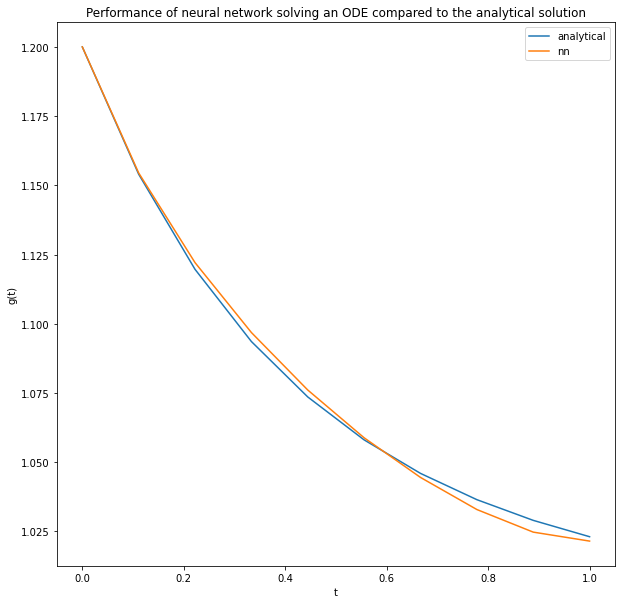

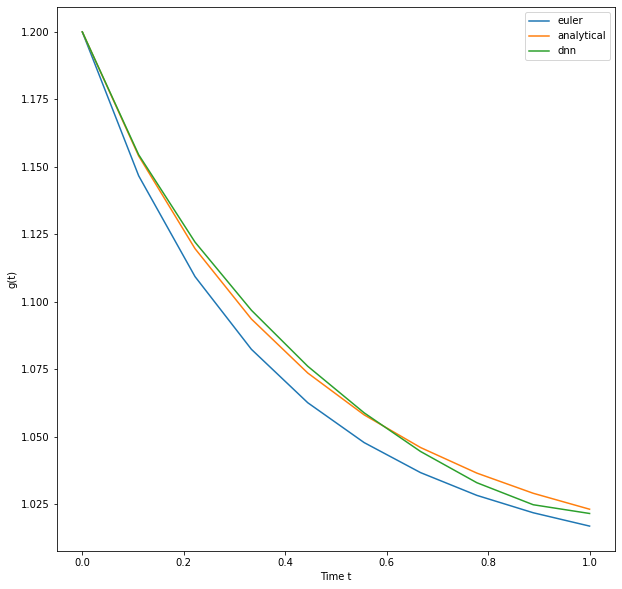

In [2]:
# Assume that all function definitions from the example program using Autograd
# are located here.

if __name__ == '__main__':
    npr.seed(4155)

    ## Decide the vales of arguments to the function to solve
    Nt = 10
    T = 1
    t = np.linspace(0,T, Nt)

    ## Set up the initial parameters
    num_hidden_neurons = [100,50,25]
    num_iter = 1000
    lmb = 1e-3

    P = solve_ode_deep_neural_network(t, num_hidden_neurons, num_iter, lmb)

    g_dnn_ag = g_trial_deep(t,P)
    g_analytical = g_analytic(t)

    # Find the maximum absolute difference between the solutons:
    diff_ag = np.max(np.abs(g_dnn_ag - g_analytical))
    print("The max absolute difference between the solutions is: %g"%diff_ag)

    plt.figure(figsize=(10,10))

    plt.title('Performance of neural network solving an ODE compared to the analytical solution')
    plt.plot(t, g_analytical)
    plt.plot(t, g_dnn_ag[0,:])
    plt.legend(['analytical','nn'])
    plt.xlabel('t')
    plt.ylabel('g(t)')

    ## Find an approximation to the funtion using forward Euler

    alpha, A, g0 = get_parameters()
    dt = T/(Nt - 1)

    # Perform forward Euler to solve the ODE
    g_euler = np.zeros(Nt)
    g_euler[0] = g0

    for i in range(1,Nt):
        g_euler[i] = g_euler[i-1] + dt*(alpha*g_euler[i-1]*(A - g_euler[i-1]))

    # Print the errors done by each method
    diff1 = np.max(np.abs(g_euler - g_analytical))
    diff2 = np.max(np.abs(g_dnn_ag[0,:] - g_analytical))

    print('Max absolute difference between Euler method and analytical: %g'%diff1)
    print('Max absolute difference between deep neural network and analytical: %g'%diff2)

    # Plot results
    plt.figure(figsize=(10,10))

    plt.plot(t,g_euler)
    plt.plot(t,g_analytical)
    plt.plot(t,g_dnn_ag[0,:])

    plt.legend(['euler','analytical','dnn'])
    plt.xlabel('Time t')
    plt.ylabel('g(t)')

    plt.show()